In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_style('darkgrid')
import datetime as dt
import yfinance as yf
import os

In [18]:
sentiment_df = pd.read_csv('./sentiment_data.csv')

In [20]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date', 'symbol'])
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments'] / sentiment_df['twitterLikes']
sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20)&(sentiment_df['twitterComments'] > 10)]
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

In [32]:
# aggregate by date and symbol
aggregated_df = sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='ME'), 'symbol'])[['engagement_ratio']].mean() # calculate the mean engagement ratio by month and symbol
aggregated_df['rank'] = aggregated_df.groupby(level=0)['engagement_ratio'].transform(lambda x: x.rank(ascending=False)) # group by month and rank the engagement ratio
aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

In [38]:
# select top 5 months for each month
filtered_df = aggregated_df[aggregated_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1) # reset symbol index
filtered_df.index = filtered_df.index + pd.DateOffset(months=1) # add one month to the index
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])
filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-30 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-28 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

In [40]:
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-30': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-31': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-28': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-28': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-30': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-30': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-30': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-30': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-31': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-30': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-30': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-30': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-30': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-31': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-28': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [67]:
# download fresh stock pries
stock_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
print(f'Found {len(stock_list)} symbols')
print(f'Downloading data from {sentiment_df.index.get_level_values("date").min()} to {sentiment_df.index.get_level_values("date").max()}')
prices_df = yf.download(stock_list, 
                          start=sentiment_df.index.get_level_values('date').min(),
                          end=sentiment_df.index.get_level_values('date').max()
                        )

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_12260/3399171754.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_df = yf.download(stock_list,
[*                      2%                       ]  2 of 85 completed

Found 85 symbols


[*********************100%***********************]  84 of 85 completed

2 Failed downloads:
['MRO', 'ATVI']: YFTzMissingError('possibly delisted; no timezone found')


In [76]:
returns_df = np.log(prices_df['Close']).diff()

In [92]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
  cols = fixed_dates[start_date]
  print(f'Columns from {start_date} to {end_date}: {cols}')
  
  temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
  portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)

portfolio_df

Columns from 2021-12-30 to 2021-12-31: ['AES', 'FCX', 'MNST', 'OXY', 'SLB']
Columns from 2022-01-31 to 2022-02-28: ['D', 'FCX', 'L', 'LUV', 'MA']
Columns from 2022-02-28 to 2022-03-31: ['AMD', 'D', 'FCX', 'LUV', 'MA']
Columns from 2022-03-28 to 2022-03-31: ['FCX', 'GILD', 'LUV', 'MRO', 'OXY']
Columns from 2022-04-30 to 2022-05-31: ['A', 'CRM', 'PFE', 'PM', 'STZ']
Columns from 2022-05-30 to 2022-05-31: ['AMD', 'CRM', 'CVX', 'J', 'KEY']
Columns from 2022-06-30 to 2022-07-31: ['AMD', 'DD', 'FCX', 'KEY', 'LMT']
Columns from 2022-07-30 to 2022-07-31: ['CB', 'CRM', 'DD', 'FCX', 'STZ']
Columns from 2022-08-31 to 2022-09-30: ['A', 'DD', 'JPM', 'REGN', 'STZ']
Columns from 2022-09-30 to 2022-10-31: ['ABT', 'DIS', 'L', 'META', 'MRNA']
Columns from 2022-10-30 to 2022-10-31: ['J', 'KEY', 'L', 'META', 'MU']
Columns from 2022-11-30 to 2022-12-31: ['A', 'DD', 'FCX', 'J', 'META']
Columns from 2022-12-30 to 2022-12-31: ['AEP', 'AES', 'DD', 'J', 'STZ']
Columns from 2023-01-31 to 2023-02-28: ['A', 'AES', 

,portfolio_return
Date,
2021-12-30,-0.000155
2021-12-31,0.003967
2022-01-31,0.022401
2022-02-01,0.015725
2022-02-02,0.006141
...,...
2022-12-27,0.003098
2022-12-28,-0.015424
2022-12-29,0.019638


In [88]:
# compare to nasdaq/qqq
qqq_df = yf.download('QQQ', 
                    start=sentiment_df.index.get_level_values('date').min(),
                    end=sentiment_df.index.get_level_values('date').max()
                    )

/var/folders/7w/ql6tsk650l71gclng0jwl69c0000gn/T/ipykernel_12260/1916309078.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq_df = yf.download('QQQ',
[*********************100%***********************]  1 of 1 completed


In [93]:
qqq_returns_df = np.log(qqq_df['Close']).diff().dropna()
portfolio_df = portfolio_df.merge(qqq_returns_df, left_index=True, right_index=True)

In [94]:
portfolio_df

,portfolio_return,QQQ
Date,,
2021-12-30,-0.000155,-0.002993
2021-12-31,0.003967,-0.006264
2022-01-31,0.022401,0.031478
2022-02-01,0.015725,0.006781
2022-02-02,0.006141,0.008092
...,...,...
2022-12-27,0.003098,-0.014239
2022-12-28,-0.015424,-0.013291
2022-12-29,0.019638,0.024083


In [96]:
portfolios_cum_return = np.exp(np.log1p(portfolio_df).cumsum())

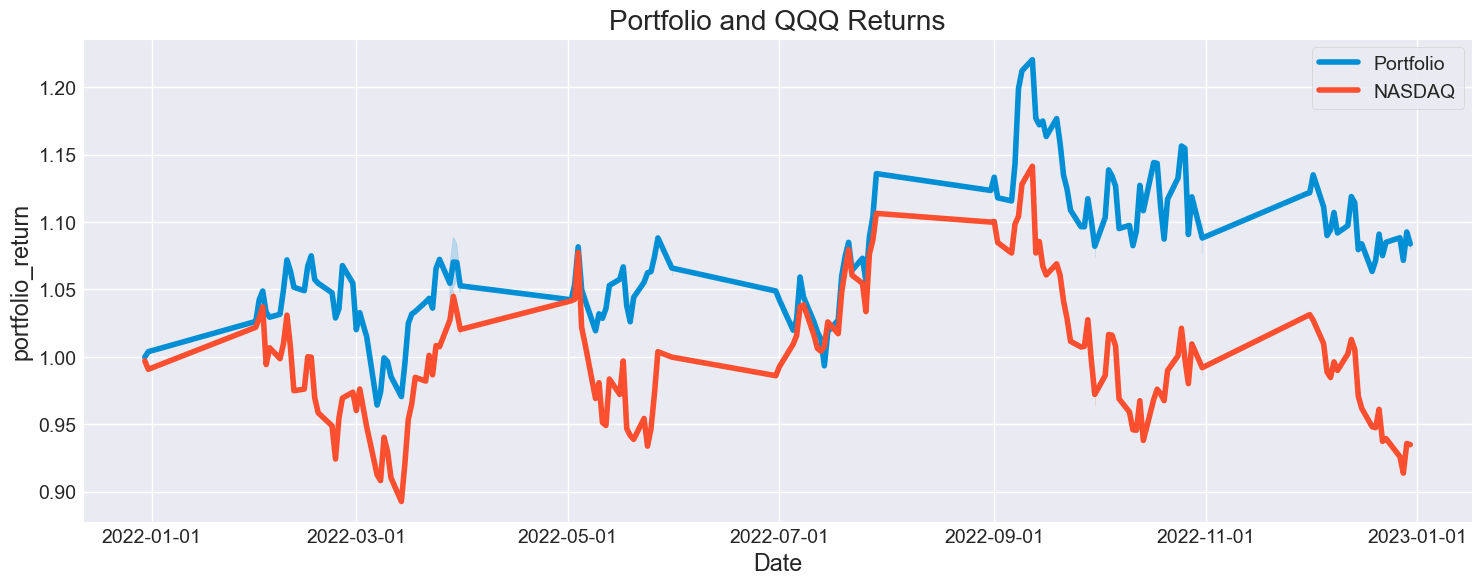

In [106]:
# plot portfolio and qqq returns
from matplotlib import dates as mdates

plt.figure(figsize=(16,6))
sns.lineplot(data=portfolios_cum_return, x=portfolios_cum_return.index, y='portfolio_return', label='Portfolio')
sns.lineplot(data=portfolios_cum_return, x=portfolios_cum_return.index, y='QQQ', label='NASDAQ')
plt.title('Portfolio and QQQ Returns')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.legend()
plt.show()
